##### Импорт дата сета

In [1]:
import numpy as np
import pandas as pd

import random
import pickle

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import chi2_contingency
from scipy.stats import boxcox

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve, KFold, RandomizedSearchCV

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
# Input
DATA_TRAIN_PATH = "course_project_train.csv"
DATA_TEST_PATH="course_project_test.csv"

In [4]:
# output
DATA_PATH_PREP = "course_project_train_prep.csv"
DATA_TEST_PATH_PREP="course_project_test_prep.csv"
FINAL_PATH = 'DSizov_predictions.csv'
# Scaler
SCALER_FILE_PATH = 'scaler.pkl'

In [5]:
# Функция заменяет пропущенные значения на медианные
def mediana(data,col):
    data.loc[data[col].isna()==True,col]=data[col].median()

In [6]:
# Функция заменяет пропущенные значения на моду
def moda(df, dt, col):
    col_mode=df[col].mode()[0]
    df.loc[df[col].isna()==True,col]=col_mode
    dt.loc[dt[col].isna()==True,col]=col_mode

In [7]:
# Функция выводит название переменной и количество наблюдений для данной переменной 
def checking(data,col):
    a=0
    for i in data[col].unique():
        if type(i)==np.nan:
            _count=data[col].isna().sum()
            print(f'{i} = {_count}')
        else:
            _count=data.loc[data[col]==i, col].count()
            print(f'{i} = {_count}')
        a+=_count
    print('Проверочная сумма',a)

In [8]:
# Данный алгоритм присваивает строковым значениям Years in current job 
# целочисленные значения 
def yearssmap(data):
    data['Years in current job']=data['Years in current job'].map({'10+ years':10,
                                    '8 years':8,
                                    '6 years':6,
                                    '7 years':7,
                                    '5 years':5,
                                    '1 year':1,
                                    '< 1 year':0,
                                    '4 years':4,
                                    '3 years':3,
                                    '2 years':2,
                                    '9 years':9
                                    }).astype(np.int64)

In [9]:
# Функция преобразует строковые значения в числовую переменную, присваивая ей числовые значения от 0 с шагом 1
def converting(data, col, pattern=None, _type=np.int64):
    if pattern==None:
        _dict={}
        _iter=0
        for names in data[col].unique():
            _dict[names]=_iter
            _iter+=1
        return data[col].map(_dict).astype(_type), _dict
    else:
        _dict=pattern
        return data[col].map(_dict).astype(_type)

In [10]:
# Замена пропущенных значений логистической регрессией
# из регулярных колонок возможно убрать 'Current Loan Amount', если данный признак также планируется чистить
def regres(df, y, reg_model = None, scaler = None, reg_cols = ['Home Ownership', 
                              'Tax Liens', 
                              'Number of Open Accounts', 
                              'Years of Credit History',
                              'Maximum Open Credit',
                              'Number of Credit Problems',
                              'Purpose', 'Term',
#                               'Current Loan Amount',
                              'Current Credit Balance',
                              'Monthly Debt',
#                               'Credit Default'
                                         ]):
    if reg_model == None:
        db = df.copy()
        db_test = db.loc[db[y].isna() == False]
        db_tofill = db.loc[db[y].isna() == True]
        
        X_train = db_test[reg_cols]
        X_test = db_tofill[reg_cols]
        y_train = db_test[y]
        
        scaler = MinMaxScaler()
        
        X_train_scale = scaler.fit_transform(X_train)
        X_test_scale = scaler.transform(X_test)
        
        regression = LinearRegression()
        reg = regression.fit(X_train_scale, y_train)
        y_pred = reg.predict(X_test_scale)
        db.loc[db[y].isna() == True, y] = y_pred
        df = db.copy()
        return df, reg, scaler
    
# Если у нас уже была обучена модель, то мы берем за основу ее
    else:
        db = df.copy()
        db_tofill = db.loc[db[y].isna() == True]
        X_test = db_tofill[reg_cols]
        
        X_test_scale = scaler.transform(X_test)
        
        y_pred = reg_model.predict(X_test_scale)
        db.loc[db[y].isna() == True, y] = y_pred
        df = db.copy()
        return df

##### Обзор обучающего дата сета

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [11]:
df=pd.read_csv(DATA_TRAIN_PATH)
dt=pd.read_csv(DATA_TEST_PATH)

In [12]:
display(df.head(5), df.shape)
display(dt.head(5), dt.shape)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


(7500, 17)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


(2500, 16)

#### Проверяем на наличие пустых значений

In [13]:
display(len(df)-df.count())
display(len(dt)-dt.count())

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

Annual Income, Years in current job, Months since last delinquent, Bankruptcies, Credit Score имеют пропущенные значения как для тренировочной выборки так и для тестовой

### Порядок обработки как обучающего так и тестового дата сета
- Пропущенные значения признака  'Years in current job' заменяем модой. Переводим значени из строковой переменной в числовую.

- Пропущенные значения признака 'Bankruptcies' заменяем модой.

- Для признаков  'Years in current job', 'Home Ownership', 'Purpose',   'Term' изменяем тип данных - строковые значения меняем на целочисленные.
  
- Отсутствующие значения признака 'Months since last delinquent' заменяем на '0'.
  
- Вводим дополнительную переменную 'Delinquent evidence', отражающую либо отсутствие задержки по выплате '0' либо наличие задержки '1'.

- Датасеты чистятся от выбросов.

- Отсутствующие численные значения Annual Income и Credit Score заменяются медианой.


### Преобразование категориальных переменных

#### Обрабатывем признак 'Years in current job' 

In [14]:
# Заменяем пропущенные значения модой
moda(df,dt,'Years in current job')

# Переводим значения из из строки в числовую переменную
yearssmap(df)
yearssmap(dt)

#### Преобразуем 'Home Ownership' из строки в числовую переменную

In [15]:
df['Home Ownership'], HomeOwnershipPattern = converting (df, 'Home Ownership')
dt['Home Ownership'] = converting(dt, 'Home Ownership', HomeOwnershipPattern)

#### Преобразуем 'Purpose' из строки в числовую переменную

In [16]:
df['Purpose'], PurposePatern = converting(df, 'Purpose')
dt['Purpose'] = converting(dt, 'Purpose', PurposePatern)

#### Преобразуем 'Term' из строки в числовую переменную

В признаке Term наблюдаем только два типа значений. Целесообразно перевести эти значения в 0 или 1

In [17]:
df['Term'], termpattern = converting(df,'Term')
dt['Term'] = converting(dt,'Term', termpattern)

#### Анализируем признак 'Bankruptcies'
Заменяем пропущенные значения модой

In [18]:
bankruptcies_mode=df['Bankruptcies'].mode()[0]
df.loc[df['Bankruptcies'].isna()==True,'Bankruptcies']=bankruptcies_mode
dt.loc[dt['Bankruptcies'].isna()==True,'Bankruptcies']=bankruptcies_mode

#### Анализируем признак 'Months since last delinquent'

In [19]:
df.loc[df['Months since last delinquent'].isna(),:].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,0,482087.0,10,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,0,0,99999999.0,47386.0,7914.0,749.0,0
1,0,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,0,1,264968.0,394972.0,18373.0,737.0,1
2,1,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,0,0,99999999.0,308389.0,13651.0,742.0,0
3,0,805068.0,6,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,0,0,121396.0,95855.0,11338.0,694.0,0
4,2,776264.0,8,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,0,0,125840.0,93309.0,7180.0,719.0,0


Предположительно отсутствующие значения признака 'Months since last delinquent' означают, что просрочки платежа у даного клиента не было. В связи с чем, отсутствующие значения целесообразно заменить на '0' 

In [20]:
df.loc[df['Months since last delinquent'].isna(),'Months since last delinquent'] = 0
dt.loc[dt['Months since last delinquent'].isna(),'Months since last delinquent'] = 0

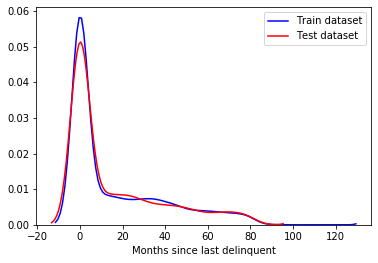

In [21]:
# Проверим гистограммы распределения 
sns.distplot(df['Months since last delinquent'], color='blue', label='Train dataset', hist=False);
sns.distplot(dt['Months since last delinquent'], color='red', label='Test dataset', hist=False);

Так как важно зафиксировать сам факт задержки выпдаты по кредиту, то целесообразно создать дополнительную переменную 'Delinquent evidence', отражающую либо отсутствие задержки по выплате **"0"** либо наличие задержки **"1"**

In [22]:
df['Delinquent evidence']=[0 if i ==0 else 1 for i in df['Months since last delinquent']]
dt['Delinquent evidence']=[0 if i ==0 else 1 for i in dt['Months since last delinquent']]

### Обработка датасетов от выбросов

#### Преобразование численных переменных


##### Проверяем пропущенные значения

In [23]:
display(len(df)-df.count())
print(40*'_')
display(len(dt)-dt.count())

Home Ownership                     0
Annual Income                   1557
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Bankruptcies                       0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
Delinquent evidence                0
dtype: int64

________________________________________


Home Ownership                    0
Annual Income                   513
Years in current job              0
Tax Liens                         0
Number of Open Accounts           0
Years of Credit History           0
Maximum Open Credit               0
Number of Credit Problems         0
Months since last delinquent      0
Bankruptcies                      0
Purpose                           0
Term                              0
Current Loan Amount               0
Current Credit Balance            0
Monthly Debt                      0
Credit Score                    513
Delinquent evidence               0
dtype: int64

#### Проверим значения на выбросы

Выпишем колонки, которые необходимо проверить на выбросы - те, которые имеют непрерывные значения

In [24]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Delinquent evidence
0,0,482087.0,10,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,0,0,99999999.0,47386.0,7914.0,749.0,0,0
1,0,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,0,1,264968.0,394972.0,18373.0,737.0,1,0
2,1,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,0,0,99999999.0,308389.0,13651.0,742.0,0,0
3,0,805068.0,6,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,0,0,121396.0,95855.0,11338.0,694.0,0,0
4,2,776264.0,8,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,0,0,125840.0,93309.0,7180.0,719.0,0,0


Для применения линейной регрессии используются все признаки за исключением 'Annual Income', 'Credit Score', 'Credit Default', так как данные признаки присутствуют не для всех наблюдений

In [25]:
# Выделим непрерывные, полу-категориальные и категориальные признаки
continuous=[]
semi_catogorical=[]
categorical=[]
for col in df.columns:
    if df[col].nunique()>=150:
        continuous.append(col)
    elif df[col].nunique()<150 and df[col].nunique()>=20:
        semi_catogorical.append(col)
    else:
        categorical.append(col)
        
# Убираем целевую переменную 'Credit Default'
categorical.remove('Credit Default')

print(f'Непрерывные признаки \n {continuous}')
print(30*'.')
print(f'Полу-категориальные признаки \n {semi_catogorical}')
print(30*'.')
print(f'Категориальные признаки \n {categorical}')
print(30*'.')

Непрерывные признаки 
 ['Annual Income', 'Years of Credit History', 'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
..............................
Полу-категориальные признаки 
 ['Number of Open Accounts', 'Months since last delinquent']
..............................
Категориальные признаки 
 ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term', 'Delinquent evidence']
..............................


In [26]:
# Данная функция выводит три графика: boxplot для тренировочного и тестового датасета и Гистограмму
def plt_outlying_cases (df, dt, col_name):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    fig.tight_layout() 
    axes[0].set_title('Train Data set')
    axes[1].set_title('Test Data set')
    axes[2].set_title('Histogram')
    sns.boxplot(df[col_name],color='b', orient='v', ax=axes[0])
    sns.boxplot(dt[col_name], color='r', orient='v', ax=axes[1])
    sns.distplot(df[col_name], color='b', ax=axes[2], hist=False, label='Train')
    sns.distplot(dt[col_name], color='r', ax=axes[2], hist=False, label='Test')
    plt.show();

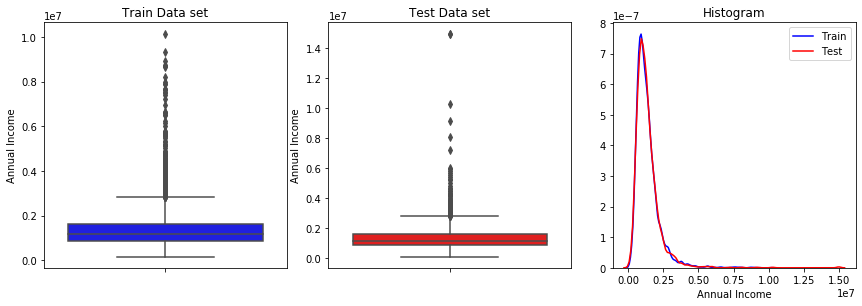

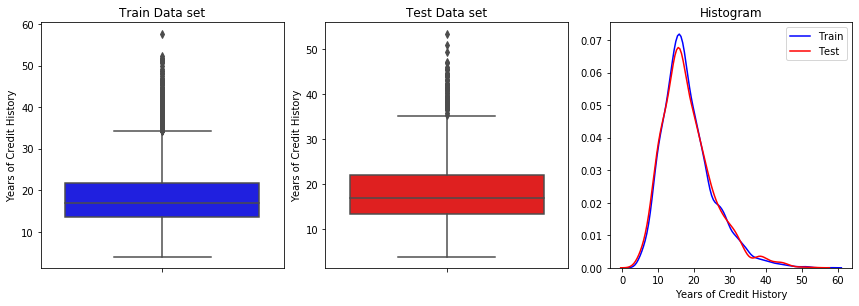

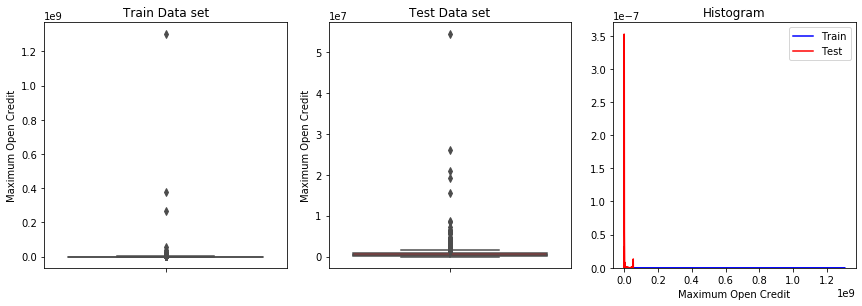

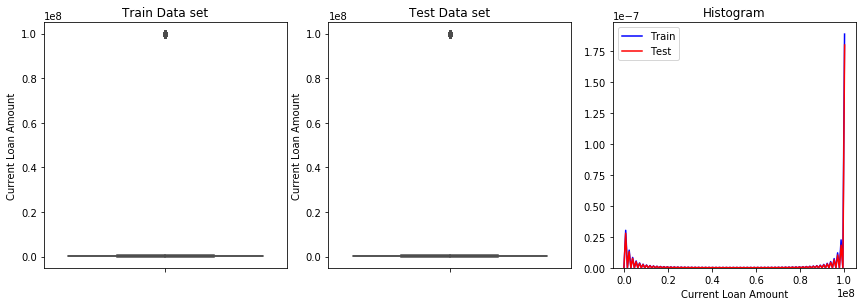

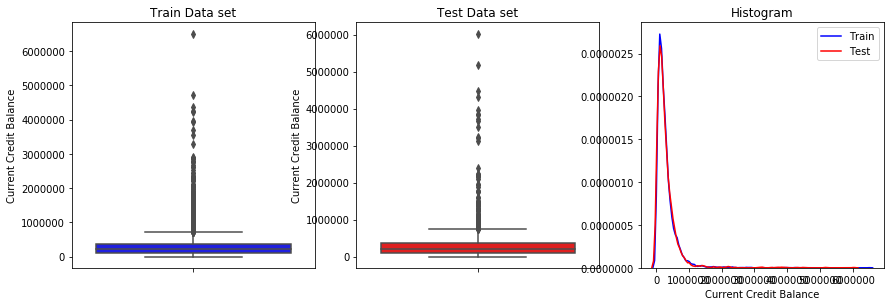

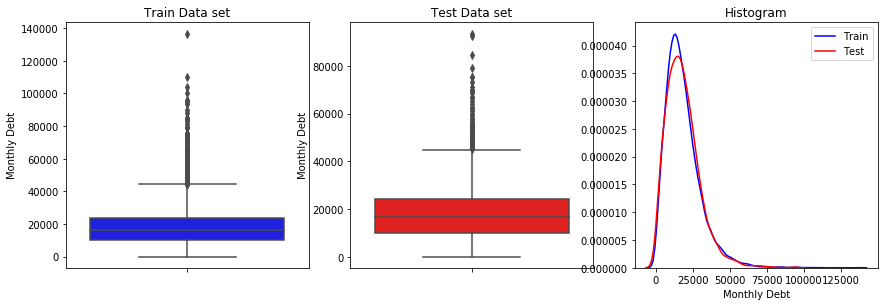

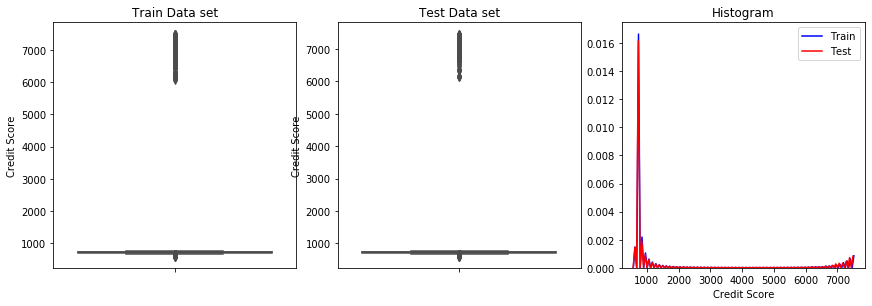

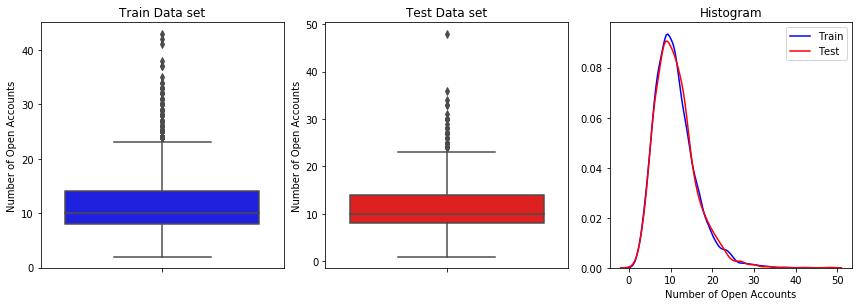

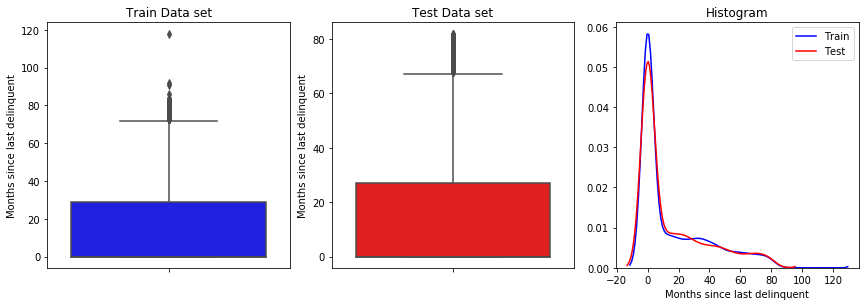

In [27]:
col_check=continuous+semi_catogorical
for name in col_check:
    plt_outlying_cases (df, dt, name)

#### Проанализируем и уберем выбросы

Выбросы:
- 'Current Loan Amount' = 99999999.0 заменяем на на None для того, чтобы далее используя унифицированный алгоритм регрессии заменить их на значения, найденные с помощью линейной регрессии
- 'Maximum Open Credit' - значения выше 10e7 и равные 0 - удаляем строки
- 'Credit Score' - значения больше 2000 делим на 10
- 'Current Credit Balance' - за выбросы принимаем значения большие 50% от максимального значения как выбросы - удаляем строки для тренировочного датасета. Для тестового датасета заменяем выбросы на медиану. Нулевые значения заменяем на медиану.
- 'Annual Income' - за границу выбросов принимаем значения больше 8000000. Данные значени заменяем на None, и после обрабатываем с помощью плгоритма линейной регрессии
- Пропущенные численные непрерывные признаки 'Credit Score'б 'Annual Income', 'Current Loan Amount' заменим на медиану.
- Значения 'Months since last delinquent'>90 для тренировочного датасета удаляем

In [28]:
# Заменим выбросы 'Current Loan Amount' на None
df.loc[df['Current Loan Amount'] == 99999999.0,'Current Loan Amount'] = None
dt.loc[dt['Current Loan Amount'] == 99999999.0,'Current Loan Amount'] = None

In [29]:
# Выпишем индексы выбросов 'Maximum Open Credit'
outlying_open_credit_df = df.loc[(df['Maximum Open Credit'] >= 10**7)|(df['Maximum Open Credit'] == 0)].index


# Удалим выбросы для тренировочного датасета и заменим выбросы для тестового датасета
df.drop(index = outlying_open_credit_df, axis = 0, inplace=True)
dt.loc[(dt['Maximum Open Credit'] >= 10**7)|(dt['Maximum Open Credit'] == 0), 'Maximum Open Credit'] = df['Maximum Open Credit'].median()

#### Подчистим от выбросов 'Credit score'

In [30]:
# У нас есть скопление значений 'Credit Score' выше 2000 тысяч. Данные значения делим на 10.
def CredSc(data):
    data.loc[data['Credit Score']>2000,'Credit Score']=data.loc[data['Credit Score']>2000,'Credit Score']/10

In [31]:
CredSc(df)
CredSc(dt)

#### Подчистим от выбросов 'Current Credit Balance'

In [32]:
# Выпишем индексы выбросов 'Current Credit Balance'
credit_balance_max = df['Current Credit Balance'].max()*0.5
outlying_credit_balance_df = df.loc[df['Current Credit Balance'] >= credit_balance_max].index

# Удалим выбросы для тренировочного датасета и заменим выбросы для тестового датасета
df.drop(index = outlying_credit_balance_df, axis = 0, inplace = True)
dt.loc[(dt['Current Credit Balance'] >= credit_balance_max)|(dt['Current Credit Balance']==0), 'Current Credit Balance'] = df['Current Credit Balance'].median()

#### Подчистим от выбросов 'Anual income'

In [33]:
df.loc[df['Annual Income']>8000000, 'Annual Income'] = None
dt.loc[dt['Annual Income']>8000000, 'Annual Income'] = None

#### Подчистим от выбросов 'Months since last delinquent'

In [34]:
# Выпишем индексы выбросов 'Months since last delinquent'
outlying_delinquent_df=df.loc[df['Months since last delinquent']>90].index

# Удалим выбросы
df.drop(index = outlying_delinquent_df, axis = 0, inplace = True)

### Медианы

In [35]:
mediana(df,'Credit Score')
mediana(dt,'Credit Score')
mediana(df,'Annual Income')
mediana(dt,'Annual Income')
mediana(df,'Current Loan Amount')
mediana(dt,'Current Loan Amount')

#### Линейная регрессия

Результаты работы алгоритма линейной регрессии показали более низкие результаты, чем замена пропущенных значений медианой. В связи с чем данный алгоритм решено не использовать

In [36]:
# len(df)-df.count()

#### Оценка признаков в разрезе целевой переменной


Оценим категориальные признаки в разрезе целевой переменной

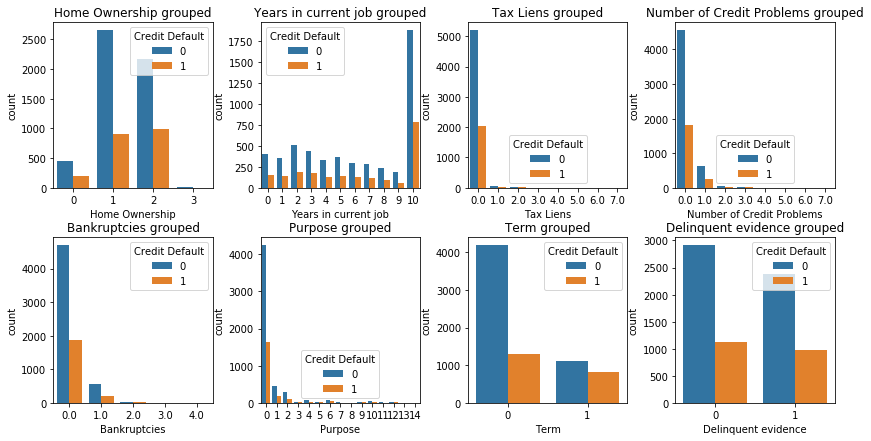

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 7))

plt.subplots_adjust(wspace=0.3, hspace=0.3)
for en,axi in enumerate(axes.flatten()):
        
    nam=categorical[en]

    sns.countplot(x=nam, hue='Credit Default', data=df, ax=axi)
    axi.set_title(f'{nam} grouped')

plt.show();

Обратим внимание на признак Home ownership

#### Анализ признака Home ownership

Значения переменных Home ownership {'Own Home': 0, 'Home Mortgage': 1, 'Rent': 2, 'Have Mortgage': 3}

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты для Home Mortgage и Have Mortgage согласованы 
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий 1 и 3 признака 'Home Ownership' в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

#### Сформируем выборку и рассчитаем наблюдаемые частоты


In [38]:
df_pirson=df.copy()
df_pirson['ID']=df_pirson.index
home_own_and_target_s = df_pirson.loc[df_pirson['Home Ownership'].isin([1, 3]),
                               ['ID','Home Ownership', 'Credit Default']]

table = home_own_and_target_s.pivot_table(values='ID', index='Home Ownership',
                              columns = 'Credit Default', aggfunc='count')
table

Credit Default,0,1
Home Ownership,,
1,2656,911
3,9,2


Проверим нашу гипотезу используя критерий Хи-квадрат Пирсона


In [39]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
round(p,9)

0.576229135

В соответствии с критерием Хи-квадрат Пирсона уровень значимости 0.58, что  выше уровня значимости 𝛼: 0.05. Следовательно нулевая гипотеза о том, что ожидаемые и наблюдаемые частоты согласованы принимается. Объеденим 'Home Ownership' = 1 и 'Home Ownership' = 3

In [40]:
df.loc[df['Home Ownership']==3,'Home Ownership'] = 1
dt.loc[dt['Home Ownership']==3,'Home Ownership'] = 1

### Анализ признакового пространства

#### Проверим распределения на нормальность с помощью критерия Шапиро-Уилка

In [41]:
for i in continuous:
    print(f'p-value для {i}: {shapiro(df[i])[1]}')

p-value для Annual Income: 0.0
p-value для Years of Credit History: 0.0
p-value для Maximum Open Credit: 0.0
p-value для Current Loan Amount: 0.0
p-value для Current Credit Balance: 0.0
p-value для Monthly Debt: 0.0
p-value для Credit Score: 0.0


p_value во всех случаях равны или близки 0, следовательно значения признаков не имеют нормального распределения. Для приведения распределения признаков к нормальному предлагается использовать алгоритм бокса-кокса

#### Нормализуем данные

Визуально проверим данные на нормальность распределения с помощью QQ-графика

In [42]:
to_normalize=['Current Credit Balance','Monthly Debt','Annual Income','Maximum Open Credit']

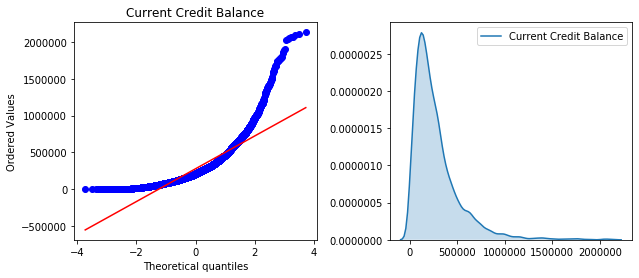

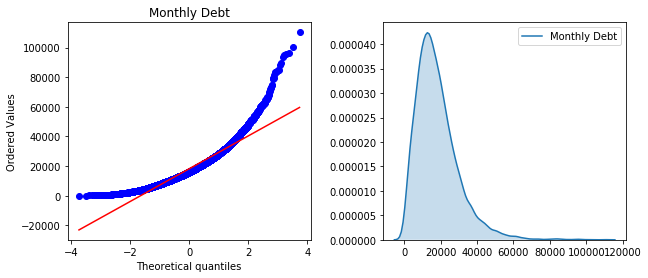

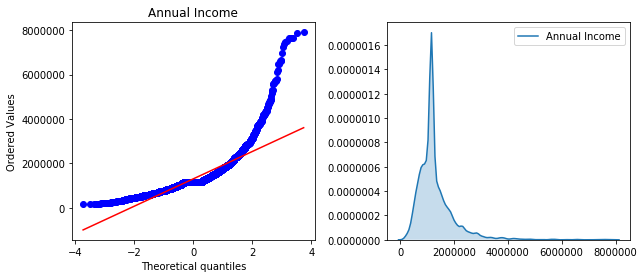

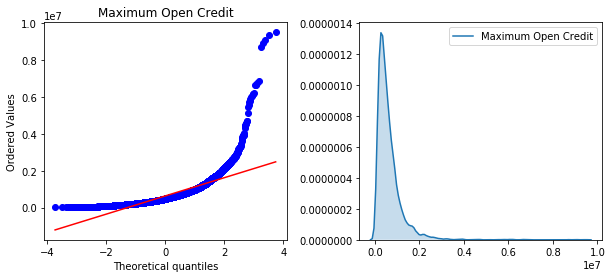

In [43]:
# Проверим тренировочный датасет
for col_name in to_normalize:
    fig, axes=plt.subplots(ncols=2, nrows=1, figsize=(10,4))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    ax1, ax2 = axes.flatten()
    probplot(df[col_name], dist='norm', plot=ax1)
    ax1.set_title(col_name)
    sns.kdeplot(df[col_name], shade=True, label=col_name, ax=ax2)

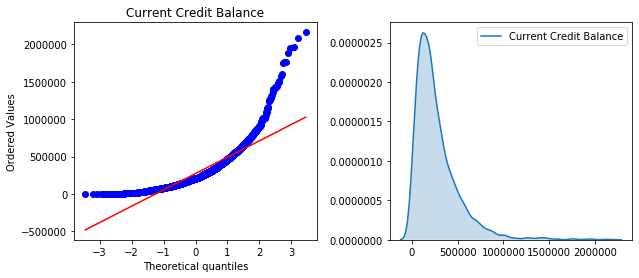

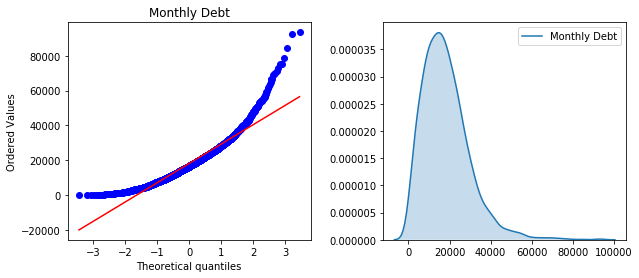

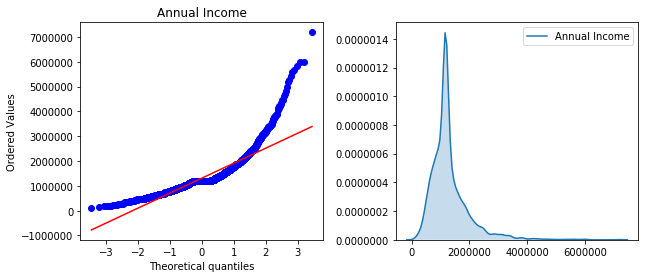

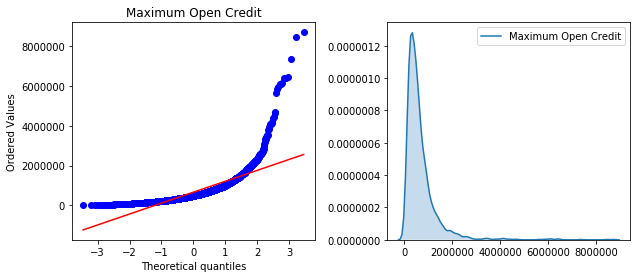

In [44]:
# Проверим тестовый датасет
for col_name in to_normalize:
    fig, axes=plt.subplots(ncols=2, nrows=1, figsize=(10,4))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    ax1, ax2 = axes.flatten()
    probplot(dt[col_name], dist='norm', plot=ax1)
    ax1.set_title(col_name)
    sns.kdeplot(dt[col_name], shade=True, label=col_name, ax=ax2)

Отклонение "хвостов" также свидетельствует об отсутствии нормального распределения 

#### Преобразуем данные с помощью алгоритма Бокса Кокса

In [45]:
# Преобразуем тренировочный датасет
df['Current Credit Balance'], lmbda_df1 = boxcox(df['Current Credit Balance'])
df['Monthly Debt'], lmbda_df2 = boxcox(df['Monthly Debt'])
df['Annual Income'], lmbda_df3 = boxcox(df['Annual Income'])
df['Maximum Open Credit'], lmbda_df4 = boxcox(df['Maximum Open Credit'])

# Преобразуем тестовый датасет
dt['Current Credit Balance'], lmbda_dt1 = boxcox(dt['Current Credit Balance'])
dt['Monthly Debt'], lmbda_dt2 = boxcox(dt['Monthly Debt'])
dt['Annual Income'], lmbda_dt3 = boxcox(dt['Annual Income'])
dt['Maximum Open Credit'], lmbda_dt4 = boxcox(dt['Maximum Open Credit'])

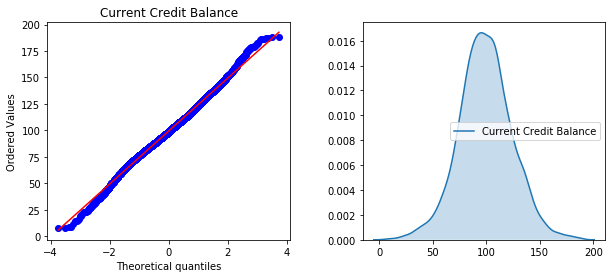

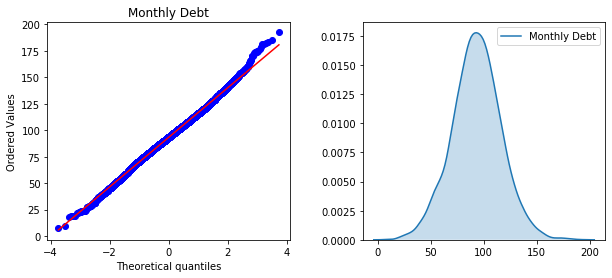

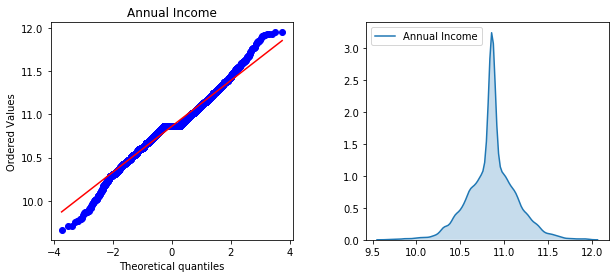

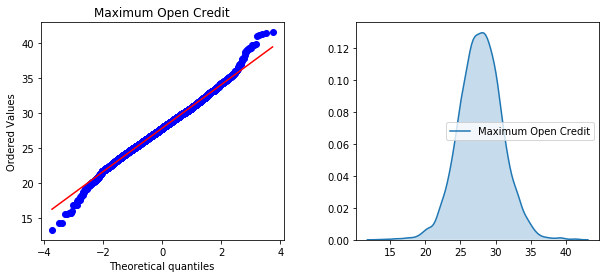

In [46]:
# Проверим тренировочный датасет
for col_name in to_normalize:
    fig, axes=plt.subplots(ncols=2, nrows=1, figsize=(10,4))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    ax1, ax2 = axes.flatten()
    probplot(df[col_name], dist='norm', plot=ax1)
    ax1.set_title(col_name)
    sns.kdeplot(df[col_name], shade=True, label=col_name, ax=ax2)

После преобразования Бокса Кокса отклонения хвостов стали значительно меньше от диагонали. Следовательно данные выровнялись.

### Преобразуем переменные в dummie

Выберем переменные, которые стоит преобразовать в dummie переменные

In [47]:
for name in categorical:
    print(f'{name} \n уникальные переменные {df[name].unique()}\n тип переменных {df[name].dtypes}\n')

Home Ownership 
 уникальные переменные [0 1 2]
 тип переменных int64

Years in current job 
 уникальные переменные [10  8  6  7  1  0  4  3  2  5  9]
 тип переменных int64

Tax Liens 
 уникальные переменные [0. 3. 1. 2. 4. 6. 5. 7.]
 тип переменных float64

Number of Credit Problems 
 уникальные переменные [1. 0. 3. 2. 6. 4. 5. 7.]
 тип переменных float64

Bankruptcies 
 уникальные переменные [1. 0. 3. 2. 4.]
 тип переменных float64

Purpose 
 уникальные переменные [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 тип переменных int64

Term 
 уникальные переменные [0 1]
 тип переменных int64

Delinquent evidence 
 уникальные переменные [0 1]
 тип переменных int64



Из выбранных переменных категориальными в чистом виде являются Home Ownership, Purpose, Term, Delinquent evidence
При этом Term, Delinquent evidence имеют только по два значения. 


Проверим признак Purpose - все ли уникальные значения данного признака из тренировочного сета имеются в тестовом

In [48]:
for j in df['Purpose'].unique():
    if j not in dt['Purpose'].unique():
        print ('Purpose', j)
        print ('Количество наблюдений ', df.loc[df['Purpose']==j, 'Purpose'].count())

Purpose 14
Количество наблюдений  2


Установлено, что в тестовом датасете отсутствует признак 'Purpose 14'. Так как для данного признака в тренировочном датасете наблюдается только два наблюдения, то целесообразно их удалить

In [49]:
purpose_14_index=df.loc[df['Purpose']==14].index
df.drop(index=purpose_14_index, axis=0, inplace=True)

### Преобразуем  переменные в int64 и создаем dummie переменные

In [50]:
# Разобьем 'Home Ownership', 'Purpose' на дамми переменные
dummie=['Home Ownership', 'Purpose']
df[dummie]=df[dummie].astype(np.int64)

for cat_colname in dummie:
    df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)
    dt = pd.concat([dt, pd.get_dummies(dt[cat_colname], prefix=cat_colname)], axis=1)
    
# Удалим 'Home Ownership', 'Purpose'
df.drop(dummie, axis=1, inplace=True)
dt.drop(dummie, axis=1, inplace=True)

### Матрица корреляций


In [51]:
df.columns

Index(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Delinquent evidence',
       'Home Ownership_0', 'Home Ownership_1', 'Home Ownership_2', 'Purpose_0',
       'Purpose_1', 'Purpose_2', 'Purpose_3', 'Purpose_4', 'Purpose_5',
       'Purpose_6', 'Purpose_7', 'Purpose_8', 'Purpose_9', 'Purpose_10',
       'Purpose_11', 'Purpose_12', 'Purpose_13'],
      dtype='object')

**Высоко коррелирующие признаки предлагается преобразовать.**
- создать новую переменную путем перемножения для:
    - 'Maximum Open Credit' и 'Current Credit Balance' 
    - 'Number of Credit Problems' и 'Bankruptcies'
- так как создан новый признак 'Delinquent evidence', то признак 'Months since last delinquent' удалить


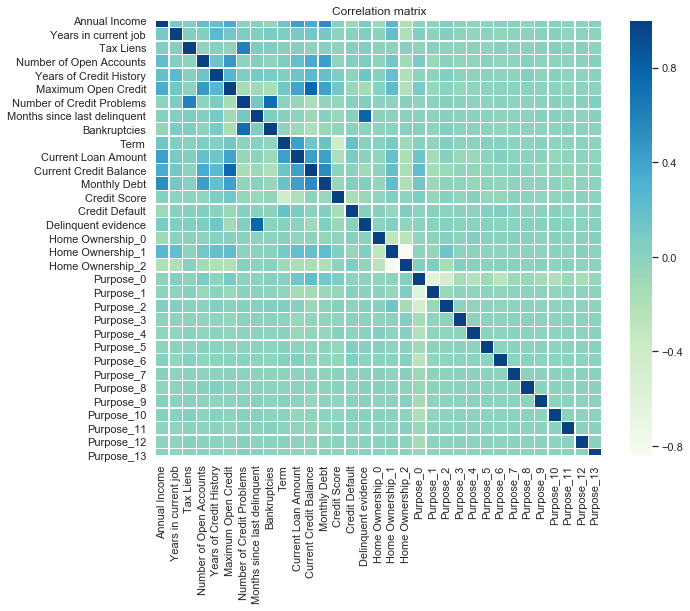

In [52]:
plt.figure(figsize = (10,8))

sns.set(font_scale=1)
sns.heatmap(df.corr().round(2), annot=False, linewidths=.3, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

#### Проверим какие признаки сильно коррелируют между собой

In [53]:
dcorr=df.corr()
CorField = []
for i in dcorr:
    for j in dcorr.index[dcorr[i] > 0.6]:
        if i != j and j not in CorField and i not in CorField:
            CorField.append(j)
            print ("%s  -->  %s: r^2=%f" % (i,j, dcorr[i][dcorr.index==j].values[0]))
    for j in dcorr.index[dcorr[i] < -0.5]:
        if i != j and j not in CorField and i not in CorField:
            CorField.append(j)
            print ("%s  -->  %s: r^2=%f" % (i,j, dcorr[i][dcorr.index==j].values[0]))

Maximum Open Credit  -->  Current Credit Balance: r^2=0.759881
Number of Credit Problems  -->  Bankruptcies: r^2=0.731382
Months since last delinquent  -->  Delinquent evidence: r^2=0.766813
Home Ownership_1  -->  Home Ownership_2: r^2=-0.840973
Purpose_0  -->  Purpose_1: r^2=-0.613505


In [54]:
# Преобразование коррелирующих признаков

df['Maximum_Credit_Current_balance']=df['Maximum Open Credit']*df['Current Credit Balance']
df.drop(['Maximum Open Credit', 'Current Credit Balance'], axis=1, inplace=True)

df['Cred_problem_bunkrupt']=df['Number of Credit Problems']*df['Bankruptcies']
df.drop(['Number of Credit Problems','Bankruptcies'], axis=1, inplace=True)

df.drop('Months since last delinquent', axis=1, inplace=True)

dt['Maximum_Credit_Current_balance']=dt['Maximum Open Credit']*dt['Current Credit Balance']
dt.drop(['Maximum Open Credit', 'Current Credit Balance'], axis=1, inplace=True)

dt['Cred_problem_bunkrupt']=dt['Number of Credit Problems']*dt['Bankruptcies']
dt.drop(['Number of Credit Problems','Bankruptcies'], axis=1, inplace=True)

dt.drop('Months since last delinquent', axis=1, inplace=True)

## Построение моделей

In [55]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [56]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()
#     target_counts = pd.value_counts(df[target_name].values.flatten())

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [57]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.4, 0.6, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [58]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [59]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Выделение целевой переменной и групп признаков


In [60]:
# убираем целевую перменную в TARGET_NAME
TARGET_NAME = 'Credit Default'

# выписываем имена  признаков  исходного дата сета
BASE_FEATURE_NAMES = df.columns[:9].tolist()

# выписываем имена признаков нового дата сета таким образом, что из подготовленного 
# дата сета выкидываем имена старого дата сета и имя целевой переменной
NEW_FEATURE_NAMES = df.columns[10:].tolist()

FTR=BASE_FEATURE_NAMES+NEW_FEATURE_NAMES

### Анализ целевой переменной

#### Обзор распределения


In [61]:
df[TARGET_NAME].value_counts()

0    5287
1    2098
Name: Credit Default, dtype: int64

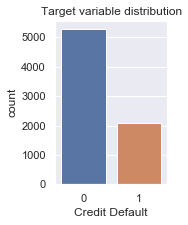

In [62]:
plt.figure(figsize=(2, 3))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

In [63]:
v0 = df[TARGET_NAME].value_counts()[0]
v1 = df[TARGET_NAME].value_counts()[1]
v1_w = (v1 / (v0 + v1)) * 100
v0_w = (v0 / (v0 + v1)) * 100
print (f'Доля значений 0: {round(v0_w, 1)}%')
print (f'Доля значений 1: {round(v1_w, 1)}%')
print (f'отношение 0/1: {round(v0_w / v1_w, 1)}')

Доля значений 0: 71.6%
Доля значений 1: 28.4%
отношение 0/1: 2.5


Установлено, что значений '1' в 2,5 раза меньше чем '0', следовательно при при обучении модели размеры выборок необходимо будет выровнять

#### Нормирование данных

In [64]:
scaler = MinMaxScaler()

df_norm=df[FTR].copy()
df_norm[FTR]=scaler.fit_transform(df_norm[FTR])
df_scale=df_norm.copy()

dt_norm=dt[FTR].copy()
dt_norm[FTR]=scaler.transform(dt_norm[FTR])
dt_scale=dt_norm.copy()

#### PCA

Метод главных компонент снизил точность модели, поэтому от него пришлось отказаться

#### Разбиение на train и test



In [65]:
X = df_scale[FTR]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

#### Балансировка целевой переменной

In [66]:
y_train.value_counts()

0    3696
1    1473
Name: Credit Default, dtype: int64

In [67]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)

df_balanced = balance_df_by_target(df_for_balancing,TARGET_NAME)    

In [68]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [69]:
y_train.value_counts()

0    3696
1    2946
Name: Credit Default, dtype: int64

##### Логистическая регрессия


In [70]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.77      0.70      3696
           1       0.62      0.45      0.52      2946

    accuracy                           0.63      6642
   macro avg       0.63      0.61      0.61      6642
weighted avg       0.63      0.63      0.62      6642

TEST

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1591
           1       0.41      0.43      0.42       625

    accuracy                           0.67      2216
   macro avg       0.59      0.60      0.59      2216
weighted avg       0.67      0.67      0.67      2216

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1210  381
1                355  270


##### k ближайших соседей

In [71]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      3696
           1       0.75      0.68      0.71      2946

    accuracy                           0.76      6642
   macro avg       0.75      0.75      0.75      6642
weighted avg       0.76      0.76      0.75      6642

TEST

              precision    recall  f1-score   support

           0       0.75      0.70      0.73      1591
           1       0.36      0.42      0.38       625

    accuracy                           0.62      2216
   macro avg       0.55      0.56      0.56      2216
weighted avg       0.64      0.62      0.63      2216

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1119  472
1                365  260


##### Бустинговые алгоритмы


XGBoost


In [72]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3696
           1       0.97      0.98      0.97      2946

    accuracy                           0.98      6642
   macro avg       0.97      0.98      0.97      6642
weighted avg       0.98      0.98      0.98      6642

TEST

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1591
           1       0.38      0.35      0.36       625

    accuracy                           0.65      2216
   macro avg       0.56      0.56      0.56      2216
weighted avg       0.65      0.65      0.65      2216

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1225  366
1                405  220


##### LightGBM


In [73]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3696
           1       0.89      0.90      0.90      2946

    accuracy                           0.91      6642
   macro avg       0.91      0.91      0.91      6642
weighted avg       0.91      0.91      0.91      6642

TEST

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1591
           1       0.41      0.42      0.42       625

    accuracy                           0.66      2216
   macro avg       0.59      0.59      0.59      2216
weighted avg       0.67      0.66      0.67      2216

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1206  385
1                360  265


###### CatBoost


In [74]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      3696
           1       0.87      0.84      0.85      2946

    accuracy                           0.87      6642
   macro avg       0.87      0.87      0.87      6642
weighted avg       0.87      0.87      0.87      6642

TEST

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1591
           1       0.43      0.46      0.44       625

    accuracy                           0.68      2216
   macro avg       0.61      0.61      0.61      2216
weighted avg       0.68      0.68      0.68      2216

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1208  383
1                337  288


### Подбор гиперпараметров

In [75]:
model_catb = catb.CatBoostClassifier(
#    class_weights=[1, 1.55], 
    silent=True,
#     cat_features=catb_cat,
    random_state=21)

In [76]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7, 10]}

In [77]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [78]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

Wall time: 3min 23s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   error_score=nan,
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000025E8092EF48>,
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [79]:
rs.best_params_

{'n_estimators': 1200, 'max_depth': 10}

In [80]:
rs.best_score_

0.7884761868509372

### Снижение степени переобучения

In [110]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=10,
                                      class_weights=[1.05, 1],
                                        l2_leaf_reg= 40,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      3696
           1       0.82      0.72      0.76      2946

    accuracy                           0.80      6642
   macro avg       0.81      0.80      0.80      6642
weighted avg       0.80      0.80      0.80      6642

TEST

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      1591
           1       0.45      0.44      0.45       625

    accuracy                           0.69      2216
   macro avg       0.61      0.61      0.61      2216
weighted avg       0.69      0.69      0.69      2216

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1249  342
1                348  277
Wall time: 3.84 s


### Подбор оптимального размера выборки, кривая обучения

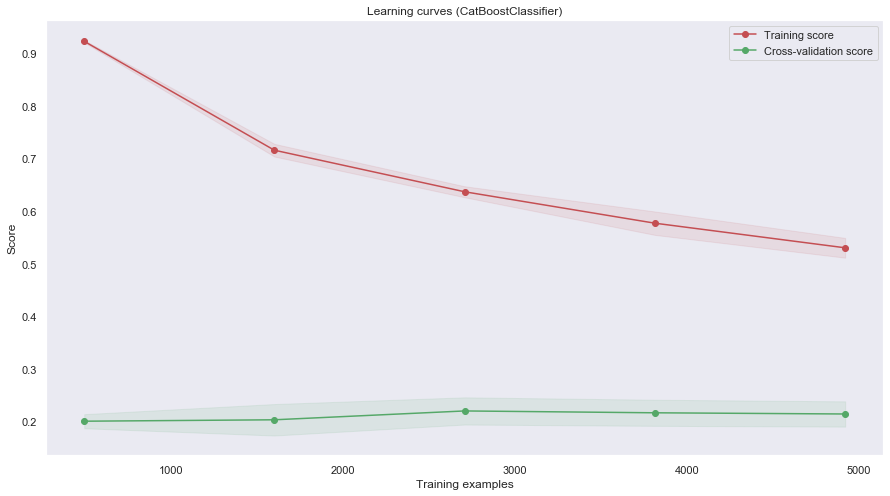

In [82]:
show_learning_curve_plot(final_model, X, y)

### Выбор порога вероятности для определения класса

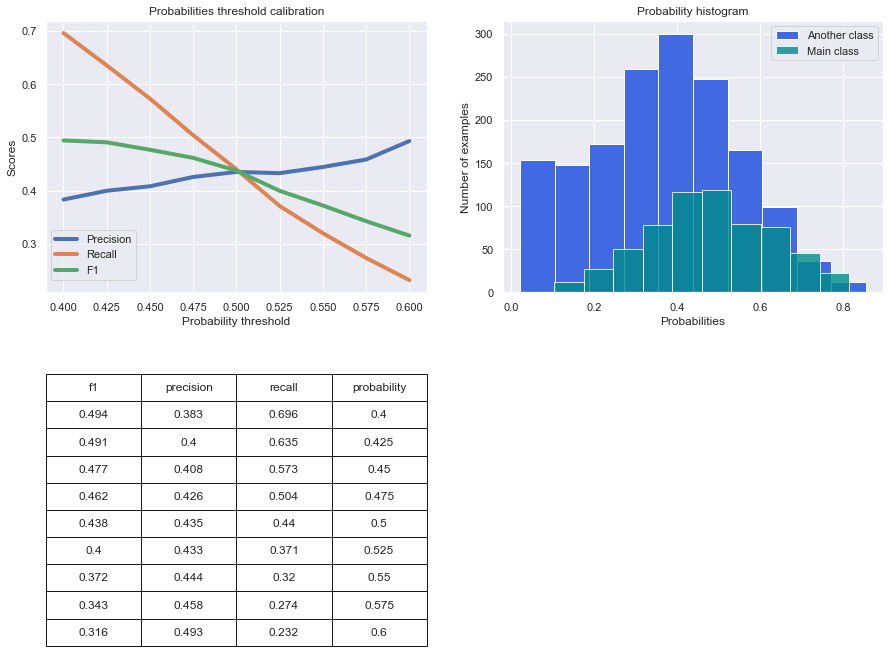

In [83]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Важность признаков

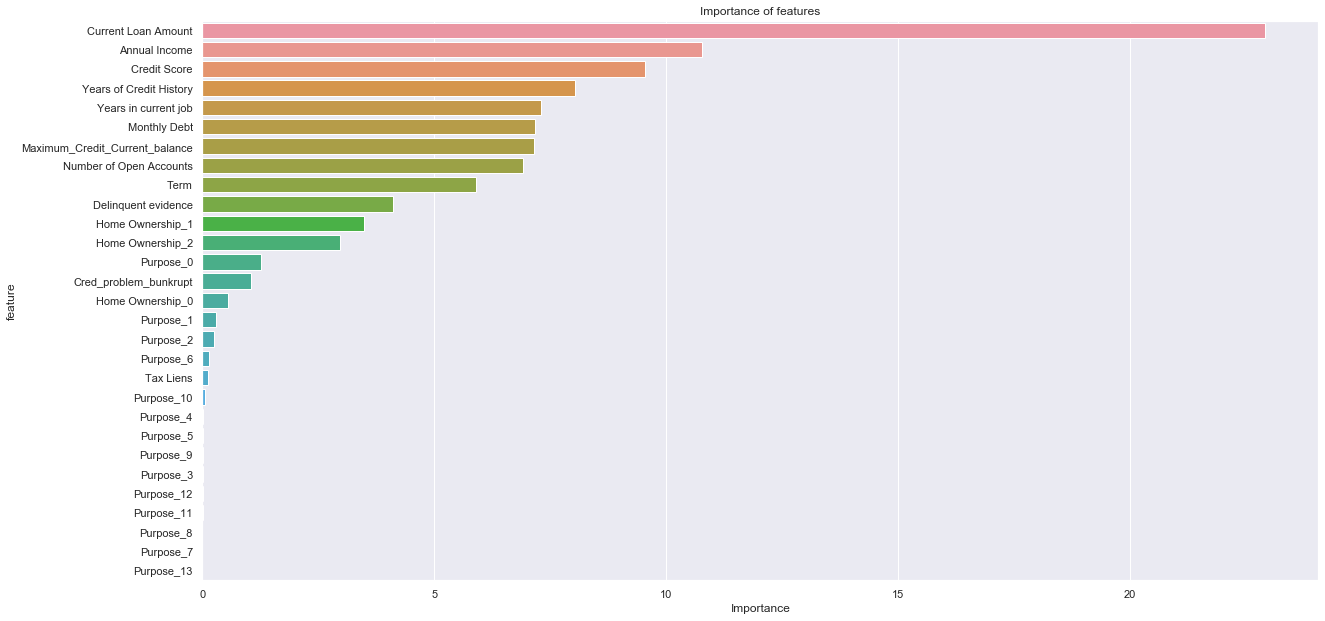

In [84]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

Подстановка "важных" параметров не улучшила качество модели

### Обучение финальной модели

In [87]:
final_model.fit(X, y)

### Преобразование тестового датасета и сохранение результатов

In [117]:
# dt_scale.describe().T.round()

In [118]:
X_pred = dt_scale

In [119]:
y_pred = final_model.predict(X_pred)

In [120]:
y_pred=pd.DataFrame(y_pred,columns=['Credit Default'])

In [121]:
y_pred.to_csv(FINAL_PATH,index=False, encoding='utf-8')